In [1]:
# python3 -m venv AB_test_env
# !source AB_test_env/bin/activate
# %pip install -r ../requirements.txt

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style and color palette
sns.set_style("darkgrid")  
sns.set_palette(sns.color_palette("Spectral"))


##############################
##  *Initial data analysis* ##
##############################
# Load data
df_control = pd.read_csv('../data/control_group.csv', sep=';') 
df_test = pd.read_csv('../data/test_group.csv', sep=';')

print(f'    * Number of null values in control group: {df_control.isnull().sum().sum()}')
print(f'* Control group info: {df_control.info()}')

print(f'    * Number of null values in test group: {df_test.isnull().sum().sum()}')
print(f'* \n\n Test group info: {df_test.info()}')


numeric_cols = df_control.select_dtypes(include=np.number).columns
print(f'Numeric columns: {numeric_cols}')

df_control.head(10)

    * Number of null values in control group: 7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        30 non-null     object 
 1   Date                 30 non-null     object 
 2   Spend [USD]          30 non-null     int64  
 3   # of Impressions     29 non-null     float64
 4   Reach                29 non-null     float64
 5   # of Website Clicks  29 non-null     float64
 6   # of Searches        29 non-null     float64
 7   # of View Content    29 non-null     float64
 8   # of Add to Cart     29 non-null     float64
 9   # of Purchase        29 non-null     float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.5+ KB
* Control group info: None
    * Number of null values in test group: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column 

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Control Campaign,6.08.2019,3083,109076.0,87998.0,4028.0,1709.0,1249.0,784.0,764.0
6,Control Campaign,7.08.2019,2544,142123.0,127852.0,2640.0,1388.0,1106.0,1166.0,499.0
7,Control Campaign,8.08.2019,1900,90939.0,65217.0,7260.0,3047.0,2746.0,930.0,462.0
8,Control Campaign,9.08.2019,2813,121332.0,94896.0,6198.0,2487.0,2179.0,645.0,501.0
9,Control Campaign,10.08.2019,2149,117624.0,91257.0,2277.0,2475.0,1984.0,1629.0,734.0


### Remove missing values

In [3]:
#########################################################
##     *Preprocessing and Linear Interpolation*        ##
# 1. Drop columns that are not needed for the analysis - `Campaign Name`
# 2. Convert date columns to datetime
# 3. Convert numeric columns to int
# 4. Linear interpolation
###########################################################

################################
##  *Linear Interpolation*    ##
################################
# Interpolation is a method to estimate missing values based on the values that are present in the data.
# Linear interpolation is a method of curve fitting using linear polynomials to construct new data points within the range of a discrete set of known data points.
# The missing values are estimated by connecting the two known data points with a straight line.

numeric_cols = df_control.select_dtypes(include=np.number).columns
assert len(numeric_cols) == df_test.select_dtypes(include=np.number).shape[1], 'Numeric columns are not the same in both dataframes'
assert df_control.shape[1] == df_test.shape[1], 'Number of columns in both dataframes are not the same'

# Preprocessing function
def preprocessing(df):
    # Drop columns that are not needed for the analysis
    df = df.drop(['Campaign Name'], axis=1)
    # Convert date columns to datetime
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)  # Convert date column
    df = df.set_index("Date").sort_index()
    df = df.interpolate(method='linear')
    # Convert numeric columns to int
    df[numeric_cols] = df[numeric_cols].astype(int)
    return df

df_control = preprocessing(df_control)
df_test = preprocessing(df_test)

df_control.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2019-08-01 to 2019-08-30
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Spend [USD]          30 non-null     int64
 1   # of Impressions     30 non-null     int64
 2   Reach                30 non-null     int64
 3   # of Website Clicks  30 non-null     int64
 4   # of Searches        30 non-null     int64
 5   # of View Content    30 non-null     int64
 6   # of Add to Cart     30 non-null     int64
 7   # of Purchase        30 non-null     int64
dtypes: int64(8)
memory usage: 2.1 KB


### Check Distributions

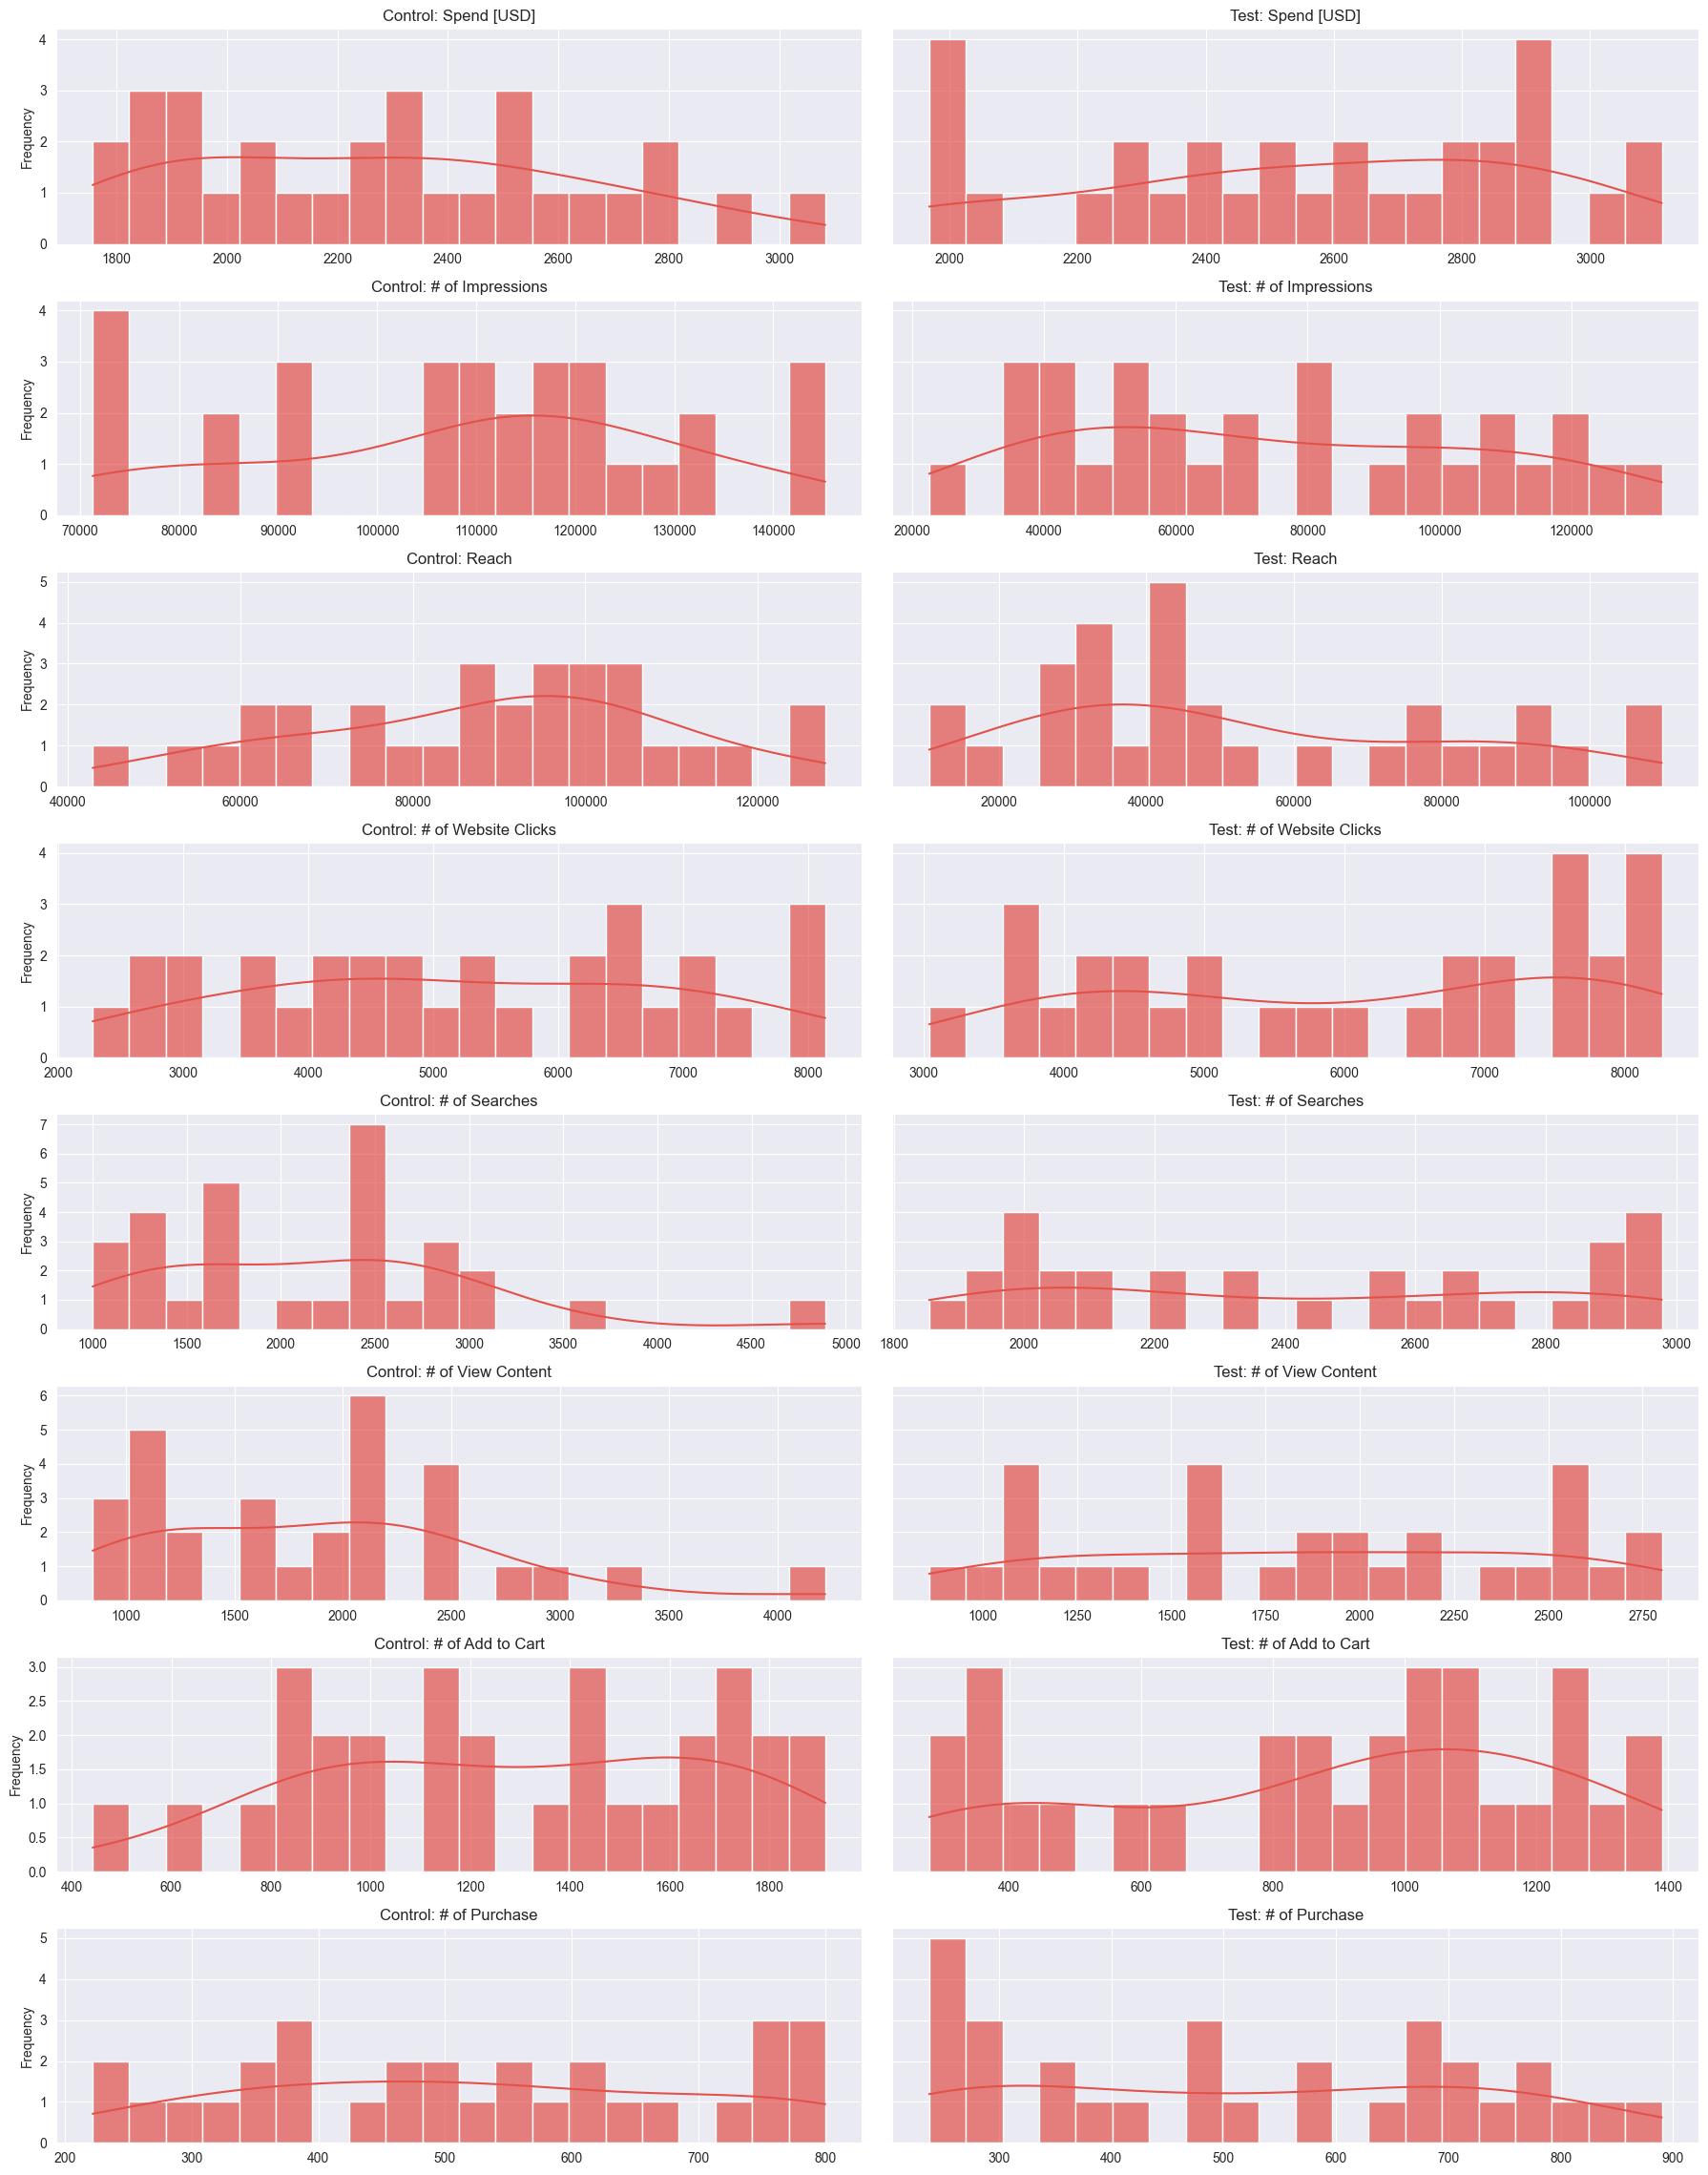

In [5]:
def plot_side_by_side_distributions(data_control, data_test, data_control_transformed=None, data_test_transformed=None, title=''):
    numeric_cols = data_control.select_dtypes(include=['number']).columns  
    num_vars = len(numeric_cols)
    
    # Set columns: 2 (if no transformed data), 4 (if transformed data is provided)
    cols = 4 if data_control_transformed is not None and data_test_transformed is not None else 2
    
    # Create subplots: one row per feature, columns based on transformation availability
    fig, axes = plt.subplots(num_vars, cols, figsize=(18, num_vars * 3), sharey='row')

    # Ensure axes is 2D even when only one variable exists
    if num_vars == 1:
        axes = np.array([axes])

    for i, col in enumerate(numeric_cols):
        # Original Control
        sns.histplot(data_control[col], kde=True, bins=20, ax=axes[i, 0], alpha=0.7)
        axes[i, 0].set_title(f'Control: {col}', fontsize=12)
        axes[i, 0].set_xlabel('')
        axes[i, 0].set_ylabel('Frequency')

        # Original Test
        sns.histplot(data_test[col], kde=True, bins=20, ax=axes[i, 1], alpha=0.7)
        axes[i, 1].set_title(f'Test: {col}', fontsize=12)
        axes[i, 1].set_xlabel('')
        axes[i, 1].set_ylabel('')

        # If transformed data is provided, plot it
        if data_control_transformed is not None and data_test_transformed is not None:
            # Transformed Control
            sns.histplot(data_control_transformed[col], kde=True, bins=20, ax=axes[i, 2], alpha=0.7)
            axes[i, 2].set_title(f'Transformed Control: {col}', fontsize=12)
            axes[i, 2].set_xlabel('')
            axes[i, 2].set_ylabel('')

            # Transformed Test
            sns.histplot(data_test_transformed[col], kde=True, bins=20, ax=axes[i, 3], alpha=0.7)
            axes[i, 3].set_title(f'Transformed Test: {col}', fontsize=12)
            axes[i, 3].set_xlabel('')
            axes[i, 3].set_ylabel('')

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage:
plot_side_by_side_distributions(df_control, df_test, 
                                'Control vs Test Group Distributions (Original vs Transformed)')


In [14]:
# Check skewness and kurtosis
def check_skewness_kurtosis(df):
    for col in df.select_dtypes(include=['number']).columns:
        skewness = stats.skew(df[col])
        kurtosis = stats.kurtosis(df[col])
        print(f"{col}: Skewness = {skewness:.2f}, Kurtosis = {kurtosis:.2f}")

print("Control Group:")
check_skewness_kurtosis(df_control)

print("\nTest Group:")
check_skewness_kurtosis(df_test)


Control Group:
Spend [USD]: Skewness = 0.35, Kurtosis = -0.86
# of Impressions: Skewness = -0.27, Kurtosis = -0.85
Reach: Skewness = -0.22, Kurtosis = -0.59
# of Website Clicks: Skewness = 0.02, Kurtosis = -1.10
# of Searches: Skewness = 0.90, Kurtosis = 1.24
# of View Content: Skewness = 0.84, Kurtosis = 0.74
# of Add to Cart: Skewness = -0.18, Kurtosis = -1.04
# of Purchase: Skewness = 0.05, Kurtosis = -1.18

Test Group:
Spend [USD]: Skewness = -0.31, Kurtosis = -0.98
# of Impressions: Skewness = 0.22, Kurtosis = -1.19
Reach: Skewness = 0.45, Kurtosis = -0.99
# of Website Clicks: Skewness = -0.18, Kurtosis = -1.47
# of Searches: Skewness = 0.09, Kurtosis = -1.54
# of View Content: Skewness = -0.04, Kurtosis = -1.28
# of Add to Cart: Skewness = -0.38, Kurtosis = -1.12
# of Purchase: Skewness = 0.08, Kurtosis = -1.38


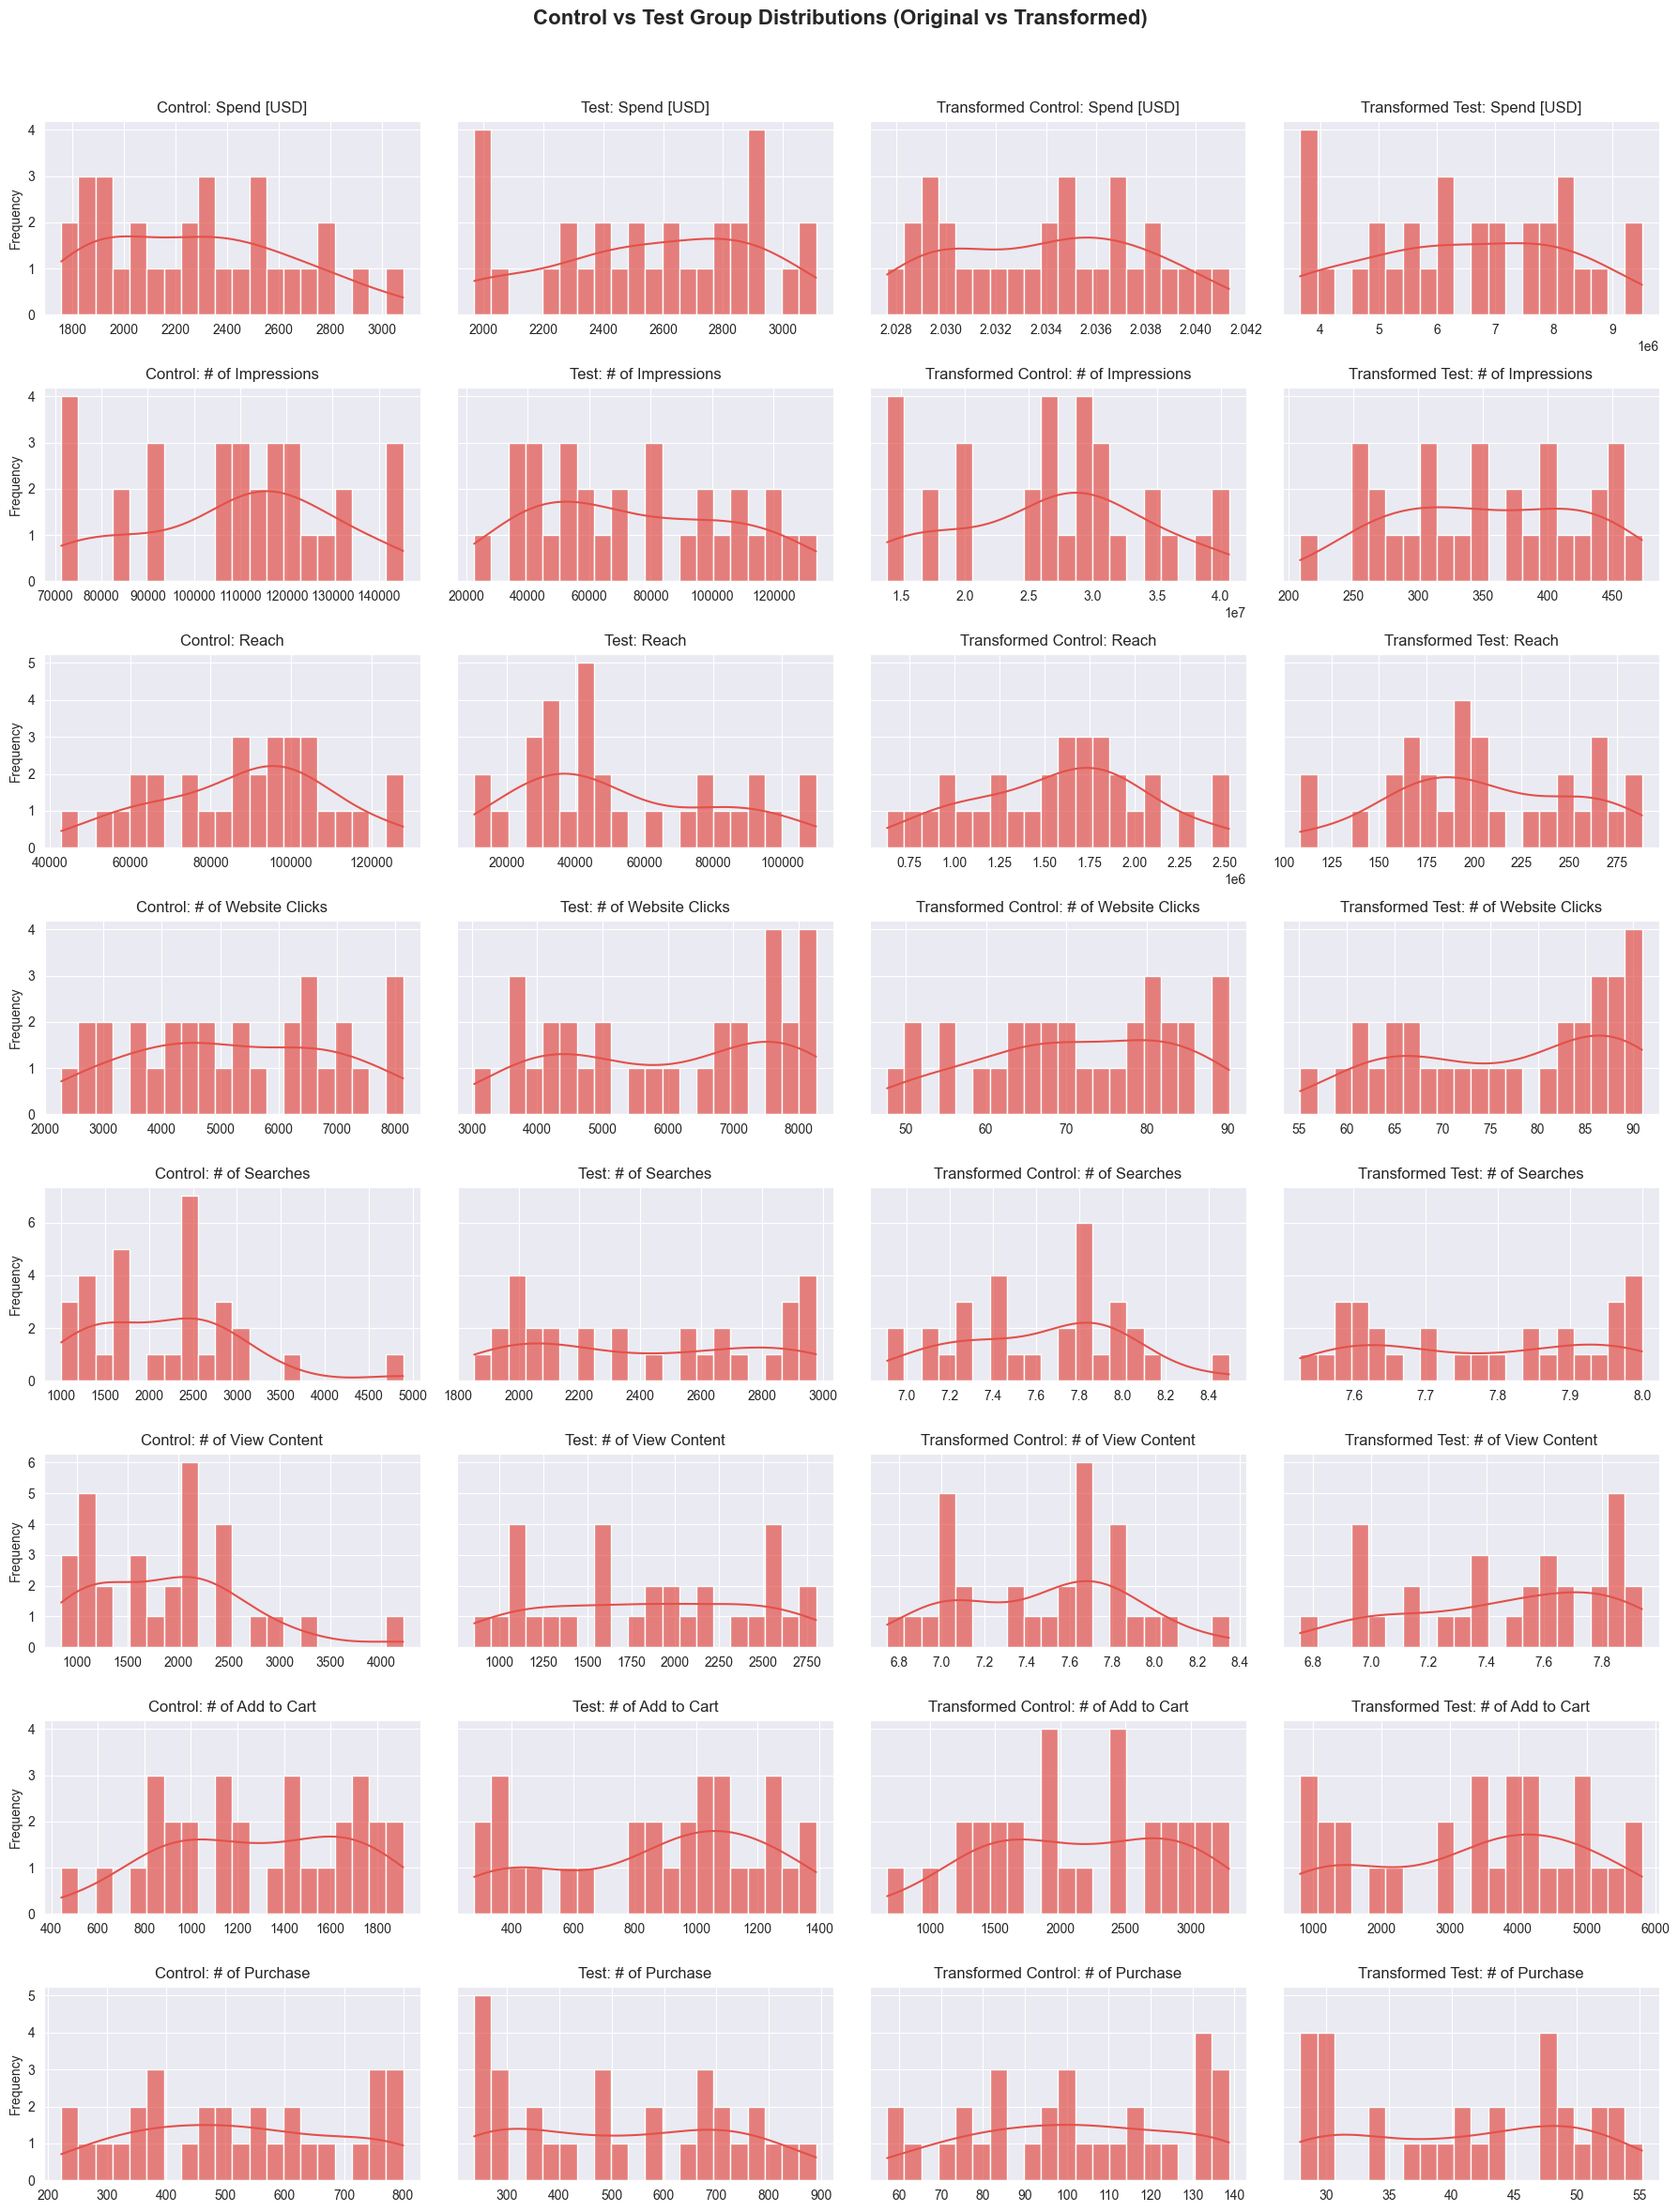

In [ ]:
################################
##  *Data Normalization*       ##
################################
# Normalization is the process of scaling individual samples to have unit norm.
# This process can be useful when you have a dataset with varying scales and you want to normalisae the data.

def normalize_data(df_control, df_test, numeric_cols):
    """
    Normalize numerical columns using appropriate transformations:
    - Log1p for highly skewed data
    - Box-Cox where suitable
    - Square root (sqrt) for moderately skewed features to avoid over-smoothing
    """

    df_control_normalised = df_control.copy()
    df_test_normalised = df_test.copy()

    # Identify columns that require more moderate transformation
    #  -  `# of Purchase: Skewness`  Kurtosis = -1.18
    #  -  `# of Website Clicks`:     Kurtosis = -1.10
    moderate_transform_cols = ['# of Purchases', '# of Website Clicks']

    
    for col in numeric_cols:
        if df_control[col].skew() > 0.8 or df_control[col].skew() < -0.8:
            # High skewness: Apply log transformation
            df_control_normalised[col] = np.log1p(df_control[col])
            df_test_normalised[col] = np.log1p(df_test[col])
        elif col in moderate_transform_cols:
            # Moderate skewness: Apply square root transformation instead of log
            df_control_normalised[col] = np.sqrt(df_control[col])
            df_test_normalised[col] = np.sqrt(df_test[col])
        else:
            # Apply Box-Cox transformation (only for strictly positive values)
            df_control_normalised[col], _ = stats.boxcox(df_control[col] + 1)  # Avoid zero errors
            df_test_normalised[col], _ = stats.boxcox(df_test[col] + 1)

    return df_control_normalised, df_test_normalised

# Normalize data
df_control_normalised, df_test_normalised = normalize_data(df_control, df_test, numeric_cols)

# Plot transformed distributions
plot_side_by_side_distributions(df_control, df_test, df_control_normalised, df_test_normalised, 
                                'Control vs Test Group Distributions (Original vs Transformed)')


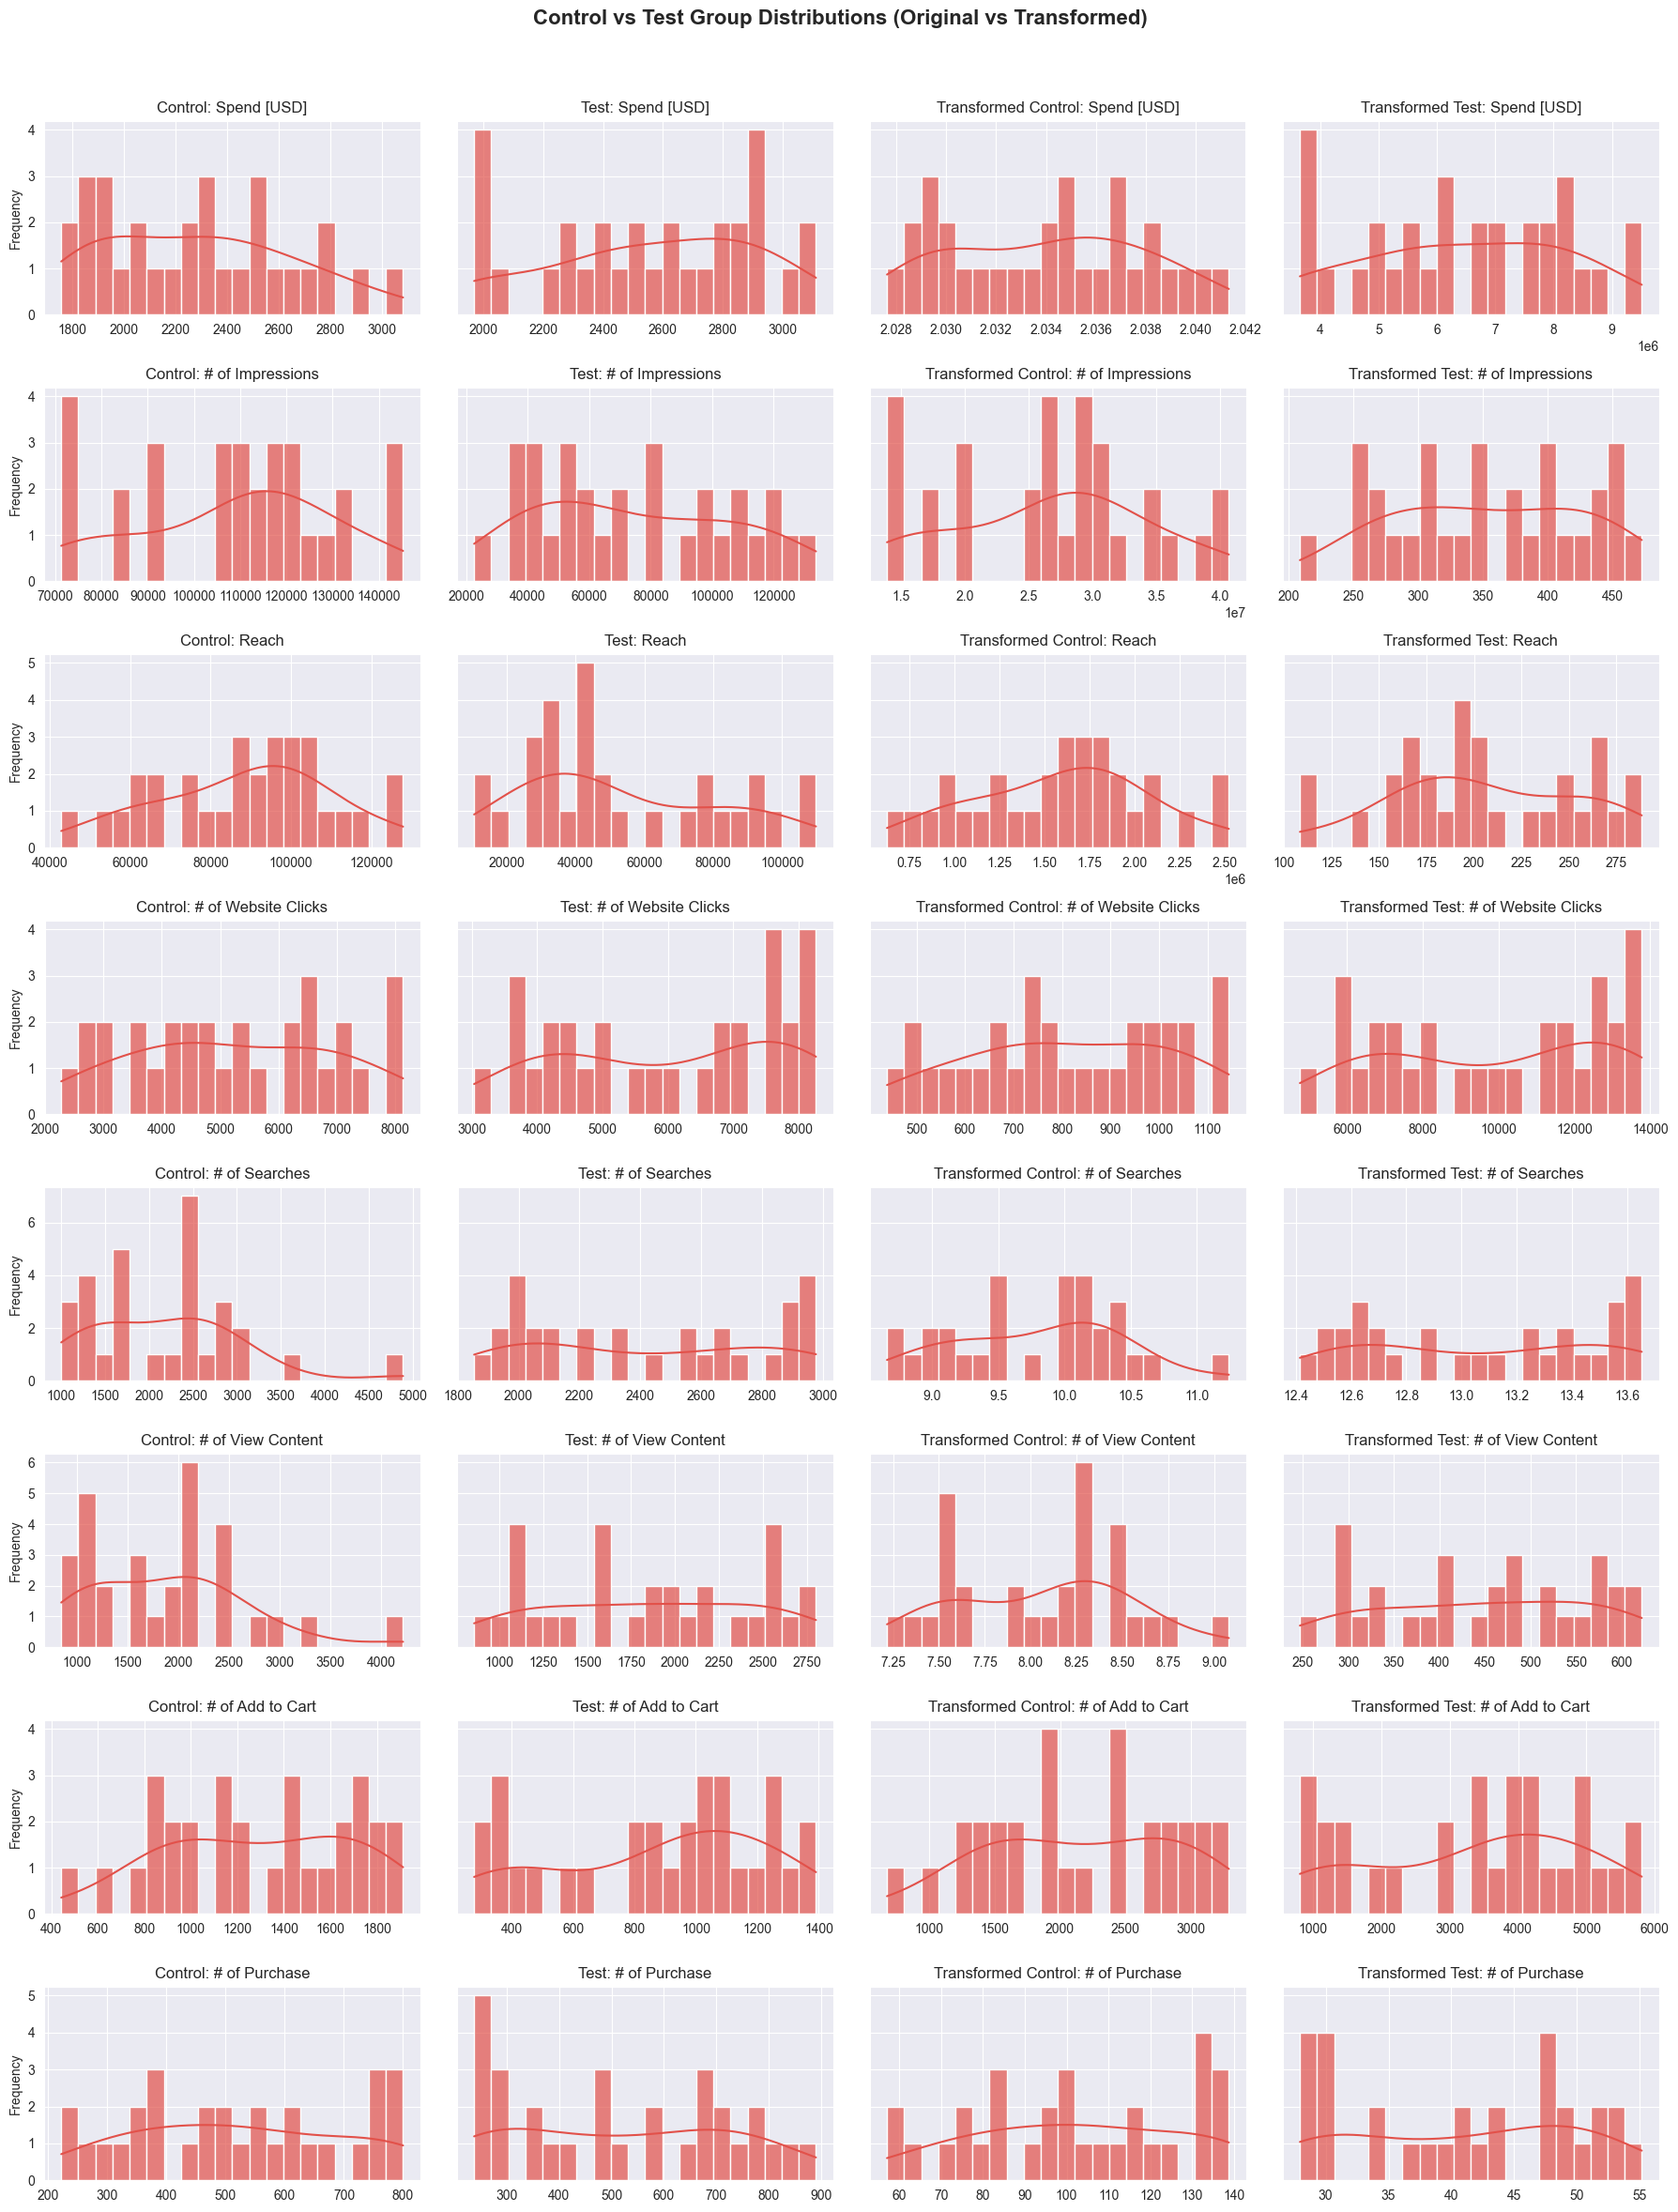

In [ ]:


# Initialize normalized dataframes
df_control_normalised = df_control.copy()
df_test_normalised = df_test.copy()
def normalize_data(df_control, df_test, numeric_cols):
    # Initialize normalized dataframes
    df_control_normalised = df_control.copy()
    df_test_normalised = df_test.copy()

    # Apply log1p transformation to numerical columns to solve skewness
    df_control_normalised[numeric_cols] = df_control[numeric_cols].apply(np.log1p)
    df_test_normalised[numeric_cols] = df_test[numeric_cols].apply(np.log1p)

    # Apply Box-Cox transformation to numerical columns
    for col in numeric_cols:
        df_control_normalised[col], _ = stats.boxcox(df_control[col] + 1)  # Adding 1 to avoid zero values
        df_test_normalised[col], _ = stats.boxcox(df_test[col] + 1)  # Adding 1 to avoid zero values

    return df_control_normalised, df_test_normalised

# Normalize data
df_control_normalised, df_test_normalised = normalize_data(df_control, df_test, numeric_cols)

# Plot transformed distributions
plot_side_by_side_distributions(df_control, df_test, df_control_normalised, df_test_normalised, 
                                'Control vs Test Group Distributions (Original vs Transformed)')


In [12]:
# Check skewness and kurtosis of transformed data
print("Transformed Control Group:")
check_skewness_kurtosis(df_control_normalised)

print("\n Transformed Test Group:")
check_skewness_kurtosis(df_test_normalised)



Transformed Control Group:
Spend [USD]: Skewness = 0.03, Kurtosis = -1.13
# of Impressions: Skewness = -0.10, Kurtosis = -0.85
Reach: Skewness = -0.08, Kurtosis = -0.62
# of Website Clicks: Skewness = -0.10, Kurtosis = -1.07
# of Searches: Skewness = -0.01, Kurtosis = -0.65
# of View Content: Skewness = -0.00, Kurtosis = -0.84
# of Add to Cart: Skewness = -0.14, Kurtosis = -1.08
# of Purchase: Skewness = -0.09, Kurtosis = -1.11

 Transformed Test Group:
Spend [USD]: Skewness = -0.11, Kurtosis = -1.06
# of Impressions: Skewness = -0.08, Kurtosis = -1.13
Reach: Skewness = -0.07, Kurtosis = -0.83
# of Website Clicks: Skewness = -0.16, Kurtosis = -1.48
# of Searches: Skewness = -0.01, Kurtosis = -1.54
# of View Content: Skewness = -0.12, Kurtosis = -1.26
# of Add to Cart: Skewness = -0.27, Kurtosis = -1.16
# of Purchase: Skewness = -0.10, Kurtosis = -1.43


In [8]:
# save the datasets
df_control.to_csv('../data/transformed_control_group.csv', index=False)
df_test.to_csv('../data/transformed_test_group.csv', index=False)
